In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import os
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision.models import efficientnet_b0
from PIL import Image
from tqdm.auto import tqdm

In [2]:
import random
import numpy as np
import torch


seed = 42
def set_seed(seed=42):
    """
    Set seed for reproducibility across numpy, torch, and random.

    Args:
        seed (int): The seed value to be set. Default is 42.
    """
    random.seed(seed)  # Python random module
    np.random.seed(seed)  # NumPy
    torch.manual_seed(seed)  # PyTorch CPU
    torch.cuda.manual_seed(seed)  # PyTorch GPU
    torch.cuda.manual_seed_all(seed)  # Multi-GPU
    torch.backends.cudnn.deterministic = True  # Ensure deterministic behavior
    torch.backends.cudnn.benchmark = False  # Disable auto-tuning for deterministic results

    print(f"Seed set to {seed}")

# Example usage:


In [3]:
# (np.concatenate([img_array,img_array,img_array])).shape

(1, 150, 150)


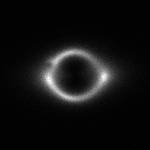

In [4]:
img_array = np.load('/kaggle/input/deeplenstask1/dataset/train/sphere/101.npy')
print(img_array.shape)
img = Image.fromarray((np.concatenate([img_array,img_array,img_array]) * 255).astype(np.uint8).transpose(1,2,0))
img

In [5]:
import os
import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import StratifiedShuffleSplit
import torchvision.transforms as transforms
from PIL import Image

print("🚀 Starting dataset setup...")

# Dataset Paths
DATASET_PATH = "/kaggle/input/deeplenstask1/dataset/train"

# Mapping class names to labels
CLASS_MAP = {"no": 0, "sphere": 1, "vort": 2}

# Define Different Transforms
print("🛠️ Setting up transformations...")

train_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # No augmentations for validation
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # No augmentations for validation
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# Custom Dataset Class
class LensDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        print("📂 Initializing Dataset...")
        self.root_dir = root_dir
        self.transform = transform
        self.data_paths = []
        self.labels = []

        # Collect file paths and labels
        for class_name, label in CLASS_MAP.items():
            class_path = os.path.join(root_dir, class_name)
            for file in os.listdir(class_path):
                if file.endswith(".npy"):
                    self.data_paths.append(os.path.join(class_path, file))
                    self.labels.append(label)
        
        print(f"✅ Loaded {len(self.data_paths)} samples.")

    def __len__(self):
        return len(self.data_paths)

    def __getitem__(self, idx):
        file_path = self.data_paths[idx]
        label = self.labels[idx]

        # Load only when needed
        img_array = np.load(file_path)
        img = Image.fromarray(((np.concatenate([img_array, img_array, img_array]) * 255).astype(np.uint8).transpose(1, 2, 0)))  # Convert to PIL

        if self.transform:
            img = self.transform(img)

        return img, label

# Load Full Dataset (Without Transforms Yet)
set_seed(seed)
full_dataset = LensDataset(DATASET_PATH)

# Convert dataset to lists for stratified split
X = full_dataset.data_paths  # Image file paths
y = full_dataset.labels      # Corresponding labels

# Stratified Split (90% Train, 10% Validation)
splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=seed)
train_idx, val_idx = next(splitter.split(X, y))

# Create Separate Dataset Instances with Different Transforms
train_dataset = LensDataset(DATASET_PATH, transform=train_transform)
train_dataset.data_paths = [X[i] for i in train_idx]
train_dataset.labels = [y[i] for i in train_idx]

val_dataset = LensDataset(DATASET_PATH, transform=val_transform)
val_dataset.data_paths = [X[i] for i in val_idx]
val_dataset.labels = [y[i] for i in val_idx]

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

print(f"📦 DataLoader ready: {len(train_dataset)} train, {len(val_dataset)} val samples.")

🚀 Starting dataset setup...
🛠️ Setting up transformations...
Seed set to 42
📂 Initializing Dataset...
✅ Loaded 30000 samples.
📂 Initializing Dataset...
✅ Loaded 30000 samples.
📂 Initializing Dataset...
✅ Loaded 30000 samples.
📦 DataLoader ready: 27000 train, 3000 val samples.


In [6]:
import torch
import torch.nn as nn
from torchvision.models import efficientnet_b0

class LensClassifier(nn.Module):
    def __init__(self, num_classes=3):
        super(LensClassifier, self).__init__()
        self.model = efficientnet_b0(weights="IMAGENET1K_V1")  # Load pretrained model

        # # Freeze all layers
        # for param in self.model.parameters():
        #     param.requires_grad = False

        # # Unfreeze only BatchNorm layers
        # for module in self.model.modules():
        #     if isinstance(module, nn.BatchNorm2d):
        #         for param in module.parameters():
        #             param.requires_grad = True

        # Modify the classifier (last layer)
        self.model.classifier[1] = nn.Linear(self.model.classifier[1].in_features, num_classes)

    def forward(self, x):
        return self.model(x)

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
# from tqdm import tqdm

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize Model
set_seed(seed)
model = LensClassifier().to(device)

# Loss & Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Training Loop
def train_model(model, train_loader, val_loader, epochs=5, model_path="best_model.pth"):
    print("🎯 Starting training...")
    best_val_acc = 0.0
    
    for epoch in range(epochs):
        model.train()
        total_loss, correct = 0, 0
        
        for batch_idx, (images, labels) in tqdm(enumerate(train_loader), total=len(train_loader)):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            correct += (outputs.argmax(1) == labels).sum().item()

            if batch_idx % (len(train_loader) // 5) == 0:
                print(f"📌 Epoch {epoch+1}, Batch {batch_idx}: Loss={loss.item():.4f}")

        train_acc = correct / len(train_loader.dataset)
        val_acc = evaluate_model(model, val_loader)
        total_loss /= len(train_loader)

        print(f"✅ Epoch {epoch+1}: Loss={total_loss:.4f}, Train Acc={train_acc:.4f}, Val Acc={val_acc:.4f}")
        
        # Save best model based on validation accuracy
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), model_path)
            print(f"🚀 Best model saved with Val Acc={best_val_acc:.4f}")

# Evaluation Function
def evaluate_model(model, val_loader):
    model.eval()
    correct = 0
    with torch.no_grad():
        for images, labels in tqdm(val_loader, total=len(val_loader)):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            correct += (outputs.argmax(1) == labels).sum().item()
    return correct / len(val_loader.dataset)

# Train the Model
train_model(model, train_loader, val_loader, epochs=10)

Seed set to 42


Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 78.8MB/s]


🎯 Starting training...


  0%|          | 0/211 [00:00<?, ?it/s]

📌 Epoch 1, Batch 0: Loss=1.0995
📌 Epoch 1, Batch 42: Loss=1.0865
📌 Epoch 1, Batch 84: Loss=0.9664
📌 Epoch 1, Batch 126: Loss=0.8972
📌 Epoch 1, Batch 168: Loss=0.6780
📌 Epoch 1, Batch 210: Loss=0.5822


  0%|          | 0/94 [00:00<?, ?it/s]

✅ Epoch 1: Loss=0.8968, Train Acc=0.5422, Val Acc=0.7363
🚀 Best model saved with Val Acc=0.7363


  0%|          | 0/211 [00:00<?, ?it/s]

📌 Epoch 2, Batch 0: Loss=0.4881
📌 Epoch 2, Batch 42: Loss=0.4054
📌 Epoch 2, Batch 84: Loss=0.5155
📌 Epoch 2, Batch 126: Loss=0.4297
📌 Epoch 2, Batch 168: Loss=0.4842
📌 Epoch 2, Batch 210: Loss=0.4185


  0%|          | 0/94 [00:00<?, ?it/s]

✅ Epoch 2: Loss=0.4810, Train Acc=0.8034, Val Acc=0.7873
🚀 Best model saved with Val Acc=0.7873


  0%|          | 0/211 [00:00<?, ?it/s]

📌 Epoch 3, Batch 0: Loss=0.3067
📌 Epoch 3, Batch 42: Loss=0.3360
📌 Epoch 3, Batch 84: Loss=0.3176
📌 Epoch 3, Batch 126: Loss=0.2515
📌 Epoch 3, Batch 168: Loss=0.2971
📌 Epoch 3, Batch 210: Loss=0.2976


  0%|          | 0/94 [00:00<?, ?it/s]

✅ Epoch 3: Loss=0.3315, Train Acc=0.8729, Val Acc=0.8610
🚀 Best model saved with Val Acc=0.8610


  0%|          | 0/211 [00:00<?, ?it/s]

📌 Epoch 4, Batch 0: Loss=0.1868
📌 Epoch 4, Batch 42: Loss=0.2063
📌 Epoch 4, Batch 84: Loss=0.2311
📌 Epoch 4, Batch 126: Loss=0.2863
📌 Epoch 4, Batch 168: Loss=0.2942
📌 Epoch 4, Batch 210: Loss=0.2378


  0%|          | 0/94 [00:00<?, ?it/s]

✅ Epoch 4: Loss=0.2516, Train Acc=0.9054, Val Acc=0.8153


  0%|          | 0/211 [00:00<?, ?it/s]

📌 Epoch 5, Batch 0: Loss=0.1868
📌 Epoch 5, Batch 42: Loss=0.2712
📌 Epoch 5, Batch 84: Loss=0.1503
📌 Epoch 5, Batch 126: Loss=0.1810
📌 Epoch 5, Batch 168: Loss=0.1907
📌 Epoch 5, Batch 210: Loss=0.2124


  0%|          | 0/94 [00:00<?, ?it/s]

✅ Epoch 5: Loss=0.2183, Train Acc=0.9194, Val Acc=0.9027
🚀 Best model saved with Val Acc=0.9027


  0%|          | 0/211 [00:00<?, ?it/s]

📌 Epoch 6, Batch 0: Loss=0.1760
📌 Epoch 6, Batch 42: Loss=0.2635
📌 Epoch 6, Batch 84: Loss=0.1585
📌 Epoch 6, Batch 126: Loss=0.2031
📌 Epoch 6, Batch 168: Loss=0.1847
📌 Epoch 6, Batch 210: Loss=0.1908


  0%|          | 0/94 [00:00<?, ?it/s]

✅ Epoch 6: Loss=0.1871, Train Acc=0.9323, Val Acc=0.8913


  0%|          | 0/211 [00:00<?, ?it/s]

📌 Epoch 7, Batch 0: Loss=0.1159
📌 Epoch 7, Batch 42: Loss=0.2508
📌 Epoch 7, Batch 84: Loss=0.1944
📌 Epoch 7, Batch 126: Loss=0.2391
📌 Epoch 7, Batch 168: Loss=0.2164
📌 Epoch 7, Batch 210: Loss=0.1160


  0%|          | 0/94 [00:00<?, ?it/s]

✅ Epoch 7: Loss=0.1634, Train Acc=0.9405, Val Acc=0.8843


  0%|          | 0/211 [00:00<?, ?it/s]

📌 Epoch 8, Batch 0: Loss=0.1359
📌 Epoch 8, Batch 42: Loss=0.1378
📌 Epoch 8, Batch 84: Loss=0.1795
📌 Epoch 8, Batch 126: Loss=0.1902
📌 Epoch 8, Batch 168: Loss=0.1550
📌 Epoch 8, Batch 210: Loss=0.2068


  0%|          | 0/94 [00:00<?, ?it/s]

✅ Epoch 8: Loss=0.1480, Train Acc=0.9470, Val Acc=0.9047
🚀 Best model saved with Val Acc=0.9047


  0%|          | 0/211 [00:00<?, ?it/s]

📌 Epoch 9, Batch 0: Loss=0.0999
📌 Epoch 9, Batch 42: Loss=0.1047
📌 Epoch 9, Batch 84: Loss=0.0653
📌 Epoch 9, Batch 126: Loss=0.0897
📌 Epoch 9, Batch 168: Loss=0.1167
📌 Epoch 9, Batch 210: Loss=0.1767


  0%|          | 0/94 [00:00<?, ?it/s]

✅ Epoch 9: Loss=0.1206, Train Acc=0.9564, Val Acc=0.8907


  0%|          | 0/211 [00:00<?, ?it/s]

📌 Epoch 10, Batch 0: Loss=0.0673
📌 Epoch 10, Batch 42: Loss=0.0620
📌 Epoch 10, Batch 84: Loss=0.1198
📌 Epoch 10, Batch 126: Loss=0.2605
📌 Epoch 10, Batch 168: Loss=0.1129
📌 Epoch 10, Batch 210: Loss=0.1073


  0%|          | 0/94 [00:00<?, ?it/s]

✅ Epoch 10: Loss=0.1118, Train Acc=0.9596, Val Acc=0.9247
🚀 Best model saved with Val Acc=0.9247


In [8]:
# Load Dataset
set_seed(seed)
VAL_PATH = "/kaggle/input/deeplenstask1/dataset/val"

validation_dataset = LensDataset(VAL_PATH, val_transform)
validation_loader = DataLoader(validation_dataset, batch_size=32, shuffle=False)

print(f"📦 DataLoader ready:{len(validation_loader)} val samples.")

Seed set to 42
📂 Initializing Dataset...
✅ Loaded 7500 samples.
📦 DataLoader ready:235 val samples.


  0%|          | 0/235 [00:00<?, ?it/s]

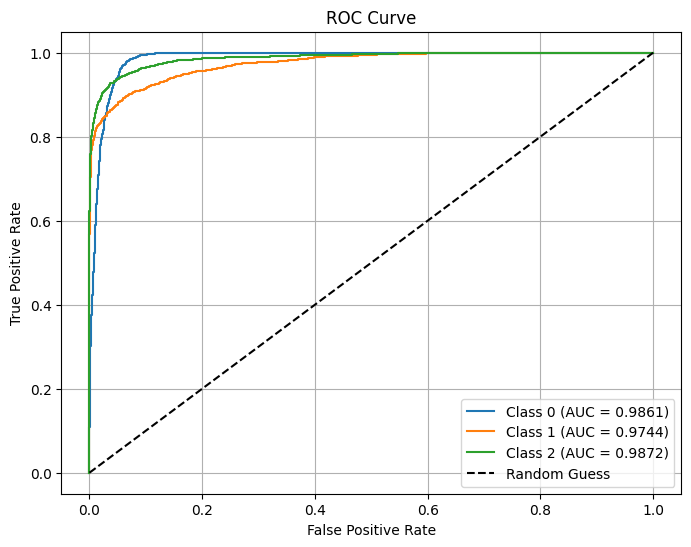

In [9]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Function to plot ROC curve and compute AUC score
def plot_roc_curve(model, val_loader, num_classes=3,model_path="best_model.pth"):
    model.load_state_dict(torch.load(model_path, weights_only=True))  # Explicitly set weights_only=True
    model.eval()
    all_probs = []
    all_labels = []

    with torch.no_grad():
        for images, labels in tqdm(val_loader):
            images = images.to(device)
            labels = labels.cpu().numpy()  # Move labels to CPU for sklearn
            outputs = model(images)
            probs = F.softmax(outputs, dim=1).cpu().numpy()  # Convert to probabilities

            all_probs.append(probs)
            all_labels.append(labels)

    # Convert lists to numpy arrays
    all_probs = np.concatenate(all_probs, axis=0)
    all_labels = np.concatenate(all_labels, axis=0)

    # Compute ROC curve and AUC for each class
    plt.figure(figsize=(8, 6))
    for i in range(num_classes):
        fpr, tpr, _ = roc_curve(all_labels == i, all_probs[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc:.4f})')

    # Plot the diagonal reference line
    plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()

# Call the function after training
plot_roc_curve(model, validation_loader, num_classes=3,model_path="best_model.pth")